In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


### Historical_Wildfires.csv
For now, I will isolate the y_target, 'Estimated_fire_area' in order to see how many missing values we have on our dependant variable.

In [2]:
wildfires = pd.read_csv('Historical_wildfires.csv')
wildfires['Date'] = pd.to_datetime(wildfires['Date'])
wildfires = pd.pivot(wildfires, index = 'Date', columns = 'Region', values = 'Estimated_fire_area')

In [3]:
wildfires.reset_index(inplace=True)
print('# of rows must equal :', len(pd.date_range(start = '2005-01-01', end = '2020-10-31')))
wildfires

# of rows must equal : 5783


Region,Date,NSW,NT,QL,SA,TA,VI,WA
0,2005-01-01,NaN,4.945000,38.831579,NaN,NaN,NaN,36.382500
1,2005-01-02,NaN,1.320000,64.464286,NaN,NaN,2.8,148.106471
2,2005-01-03,NaN,88.740000,47.386585,NaN,NaN,1.0,60.632258
3,2005-01-04,8.68000,NaN,30.100000,NaN,NaN,NaN,86.374167
4,2005-01-05,16.61125,NaN,4.000000,NaN,NaN,NaN,31.378947
...,...,...,...,...,...,...,...,...
5777,2020-10-27,1.21000,12.750000,78.670769,NaN,NaN,NaN,32.970000
5778,2020-10-28,3.00000,144.990566,119.608649,NaN,NaN,2.0,20.840625
5779,2020-10-29,NaN,53.462326,249.090625,NaN,NaN,NaN,136.083077
5780,2020-10-30,1.32000,171.325280,282.538983,NaN,NaN,2.0,42.397895


In [4]:
# Instantiating another dataframe with a daterange and merge to find the missing date.
dummy = pd.DataFrame()
dummy['Date'] = pd.date_range(start = '2005-01-01', end = '2020-10-31')

In [5]:
# 2020-03-06 have missing values for all 7 states.
wildfires_merge = pd.merge(wildfires, dummy, how = 'outer')
wildfires_merge

,Date,NSW,NT,QL,SA,TA,VI,WA
0,2005-01-01,NaN,4.945000,38.831579,NaN,NaN,NaN,36.382500
1,2005-01-02,NaN,1.320000,64.464286,NaN,NaN,2.8,148.106471
2,2005-01-03,NaN,88.740000,47.386585,NaN,NaN,1.0,60.632258
3,2005-01-04,8.68000,NaN,30.100000,NaN,NaN,NaN,86.374167
4,2005-01-05,16.61125,NaN,4.000000,NaN,NaN,NaN,31.378947
...,...,...,...,...,...,...,...,...
5778,2020-10-28,3.00000,144.990566,119.608649,NaN,NaN,2.0,20.840625
5779,2020-10-29,NaN,53.462326,249.090625,NaN,NaN,NaN,136.083077
5780,2020-10-30,1.32000,171.325280,282.538983,NaN,NaN,2.0,42.397895
5781,2020-10-31,20.27600,115.588461,297.627826,NaN,NaN,NaN,107.370851


In [6]:
wildfires_merge.sort_values(by = 'Date', inplace=True)
wildfires_merge.isna().sum()

Date       0
NSW     1160
NT       730
QL       250
SA      3793
TA      4379
VI      3607
WA       156
dtype: int64

In [7]:
melt_df = pd.melt(wildfires_merge, id_vars = 'Date')
melt_df

,Date,variable,value
0,2005-01-01,NSW,NaN
1,2005-01-02,NSW,NaN
2,2005-01-03,NSW,NaN
3,2005-01-04,NSW,8.680000
4,2005-01-05,NSW,16.611250
...,...,...,...
40476,2020-10-27,WA,32.970000
40477,2020-10-28,WA,20.840625
40478,2020-10-29,WA,136.083077
40479,2020-10-30,WA,42.397895


In [8]:
len(pd.date_range(start = '2005-01-01', end = '2020-10-31')) * 7

40481

In [9]:
melt_df.isna().sum()

Date            0
variable        0
value       14075
dtype: int64

### Imputing with boosted tree
For this step, I will try to accumulate as much data that can explain the estimated_fire_area target. <br>
This includes cleaning weather, landclass, and vegetation values.

---

# Preprocessing for Impute
### HistoricalWeather.csv

In [10]:
# I am unsure what count actually is.
weather = pd.read_csv('HistoricalWeather.csv')
weather

,Date,Region,Parameter,count()[unit: km^2],min(),max(),mean(),variance()
0,2005-01-01,NSW,Precipitation,8.002343e+05,0.000000,1.836935,0.044274,0.028362
1,2005-01-01,NSW,RelativeHumidity,8.002343e+05,13.877194,80.522964,36.355567,253.559937
2,2005-01-01,NSW,SoilWaterContent,8.002343e+05,0.002245,0.414305,0.170931,0.007758
3,2005-01-01,NSW,SolarRadiation,8.002343e+05,14.515009,32.169781,26.749389,6.078587
4,2005-01-01,NSW,Temperature,8.002343e+05,14.485785,35.878704,27.341182,18.562212
...,...,...,...,...,...,...,...,...
242776,2020-10-31,WA,RelativeHumidity,2.528546e+06,9.272744,82.022224,34.193973,309.018764
242777,2020-10-31,WA,SoilWaterContent,2.528546e+06,0.000000,0.285399,0.050737,0.001419
242778,2020-10-31,WA,SolarRadiation,2.528546e+06,17.072290,29.743744,26.746413,5.986063
242779,2020-10-31,WA,Temperature,2.528546e+06,16.238239,34.669132,28.090392,15.293953


In [11]:
# renaming columsn for easability.
weather.columns = ['Date', 'Region', 'Parameter', 'count', 'min', 'max', 'mean', 'variance']
weather['Date'] = pd.to_datetime(weather['Date'])
weather

,Date,Region,Parameter,count,min,max,mean,variance
0,2005-01-01,NSW,Precipitation,8.002343e+05,0.000000,1.836935,0.044274,0.028362
1,2005-01-01,NSW,RelativeHumidity,8.002343e+05,13.877194,80.522964,36.355567,253.559937
2,2005-01-01,NSW,SoilWaterContent,8.002343e+05,0.002245,0.414305,0.170931,0.007758
3,2005-01-01,NSW,SolarRadiation,8.002343e+05,14.515009,32.169781,26.749389,6.078587
4,2005-01-01,NSW,Temperature,8.002343e+05,14.485785,35.878704,27.341182,18.562212
...,...,...,...,...,...,...,...,...
242776,2020-10-31,WA,RelativeHumidity,2.528546e+06,9.272744,82.022224,34.193973,309.018764
242777,2020-10-31,WA,SoilWaterContent,2.528546e+06,0.000000,0.285399,0.050737,0.001419
242778,2020-10-31,WA,SolarRadiation,2.528546e+06,17.072290,29.743744,26.746413,5.986063
242779,2020-10-31,WA,Temperature,2.528546e+06,16.238239,34.669132,28.090392,15.293953


In [12]:
weather_pivot = pd.pivot(weather, index=['Date', 'Region'], columns = ['Parameter'], values = ['min', 'max', 'mean', 'variance'])
weather_pivot

min                                    \
Parameter         Precipitation RelativeHumidity SoilWaterContent   
Date       Region                                                   
2005-01-01 NSW         0.000000        13.877194         0.002245   
           NT          0.000000        14.558820         0.000000   
           QL          0.000000        14.443199         0.000000   
           SA          0.000000        10.618136         0.000000   
           TA          0.003973        43.906574         0.000000   
...                         ...              ...              ...   
2020-10-31 QL          0.000000        12.749949         0.000000   
           SA          0.000000        12.512371         0.000000   
           TA          0.000703        69.801094         0.000000   
           VI          0.000000        66.459290         0.000000   
           WA          0.000000         9.272744         0.000000   

                                                                 max  \
Parameter         SolarRadiation Temperature WindSpeed Precipitation   
Date       Region                                                      
2005-01-01 NSW         14.515009   14.485785  1.354448      1.836935   
           NT           2.518120   24.179960  1.840394    315.266815   
           QL           6.033827   20.951620  1.106028     74.452164   
           SA          17.861103   14.095855  2.023657      3.193624   
           TA          20.742302    6.686816  1.995647     13.604791   
...                          ...         ...       ...           ...   
2020-10-31 QL          19.898029   17.249844  1.180556     26.366877   
           SA          15.608338    9.948414  2.062619      0.259189   
           TA          15.503663    8.217092  1.300771      2.179307   
           VI          11.170260    9.186510  1.783996     11.436618   
           WA          17.072290   16.238239  1.704024     15.154541   

                                                                    ...  \
Parameter         RelativeHumidity SoilWaterContent SolarRadiation  ...   
Date       Region                                                   ...   
2005-01-01 NSW           80.522964         0.414305      32.169781  ...   
           NT            95.683342         0.496140      31.634459  ...   
           QL            95.898270         0.472416      31.982830  ...   
           SA            81.980751         0.263911      31.734528  ...   
           TA            81.501442         0.368189      33.225517  ...   
...                            ...              ...            ...  ...   
2020-10-31 QL            87.803581         0.442840      30.670065  ...   
           SA            82.642616         0.436347      29.623133  ...   
           TA            86.428932         0.376833      28.439209  ...   
           VI            93.374763         0.455111      28.041906  ...   
           WA            82.022224         0.285399      29.743744  ...   

                              mean                                       \
Parameter         SoilWaterContent SolarRadiation Temperature WindSpeed   
Date       Region                                                         
2005-01-01 NSW            0.170931      26.749389   27.341182  3.323550   
           NT             0.167735      19.781791   29.881492  5.296892   
           QL             0.185641      27.056979   28.842866  3.483753   
           SA             0.056047      27.142643   30.793675  4.657538   
           TA             0.211360      26.755711   11.788805  5.408138   
...                            ...            ...         ...       ...   
2020-10-31 QL             0.141467      28.745128   24.777835  3.137745   
           SA             0.083082      26.530568   18.947783  3.548225   
           TA             0.264608      21.782732   11.648813  2.501697   
           VI             0.324260      19.553751   13.167147  3.838360   
           WA             

In [13]:
# flattening multi index columns
columns = []
for i,x in weather_pivot.columns:
    columns.append('{}_{}'.format(i,x))

In [14]:
weather_pivot.columns = columns
weather_pivot

min_Precipitation  min_RelativeHumidity  \
Date       Region                                            
2005-01-01 NSW              0.000000             13.877194   
           NT               0.000000             14.558820   
           QL               0.000000             14.443199   
           SA               0.000000             10.618136   
           TA               0.003973             43.906574   
...                              ...                   ...   
2020-10-31 QL               0.000000             12.749949   
           SA               0.000000             12.512371   
           TA               0.000703             69.801094   
           VI               0.000000             66.459290   
           WA               0.000000              9.272744   

                   min_SoilWaterContent  min_SolarRadiation  min_Temperature  \
Date       Region                                                              
2005-01-01 NSW                 0.002245           14.515009        14.485785   
           NT                  0.000000            2.518120        24.179960   
           QL                  0.000000            6.033827        20.951620   
           SA                  0.000000           17.861103        14.095855   
           TA                  0.000000           20.742302         6.686816   
...                                 ...                 ...              ...   
2020-10-31 QL                  0.000000           19.898029        17.249844   
           SA                  0.000000           15.608338         9.948414   
           TA                  0.000000           15.503663         8.217092   
           VI                  0.000000           11.170260         9.186510   
           WA                  0.000000           17.072290        16.238239   

                   min_WindSpeed  max_Precipitation  max_RelativeHumidity  \
Date       Region                                                           
2005-01-01 NSW          1.354448           1.836935             80.522964   
           NT           1.840394         315.266815             95.683342   
           QL           1.106028          74.452164             95.898270   
           SA           2.023657           3.193624             81.980751   
           TA           1.995647          13.604791             81.501442   
...                          ...                ...                   ...   
2020-10-31 QL           1.180556          26.366877             87.803581   
           SA           2.062619           0.259189             82.642616   
           TA           1.300771           2.179307             86.428932   
           VI           1.783996          11.436618             93.374763   
           WA           1.704024          15.154541             82.022224   

                   max_SoilWaterContent  max_SolarRadiation  ...  \
Date       Region                                            ...   
2005-01-01 NSW                 0.414305           32.169781  ...   
           NT                  0.496140           31.634459  ...   
           QL                  0.472416           31.982830  ...   
           SA                  0.263911           31.734528  ...   
           TA                  0.368189           33.225517  ...   
...                                 ...                 ...  ...   
2020-10-31 QL                  0.442840           30.670065  ...   
           SA                  0.436347           29.623133  ...   
           TA                  0.376833           28.439209  ...   
           VI                  0.455111           28.041906  ...   
           WA                  0.285399           29.743744  ...   

                   mean_SoilWaterContent  mean_SolarRadiation  \
Date       Region                                               
2005-01-01 NSW                  0.170931            26.749389   
           NT                   0.167735            19.781791   
           QL           

In [15]:
weather_pivot.reset_index(inplace=True)
weather_pivot

,Date,Region,min_Precipitation,min_RelativeHumidity,min_SoilWaterContent,min_SolarRadiation,min_Temperature,min_WindSpeed,max_Precipitation,max_RelativeHumidity,...,mean_SoilWaterContent,mean_SolarRadiation,mean_Temperature,mean_WindSpeed,variance_Precipitation,variance_RelativeHumidity,variance_SoilWaterContent,variance_SolarRadiation,variance_Temperature,variance_WindSpeed
0,2005-01-01,NSW,0.000000,13.877194,0.002245,14.515009,14.485785,1.354448,1.836935,80.522964,...,0.170931,26.749389,27.341182,3.323550,0.028362,253.559937,0.007758,6.078587,18.562212,0.850048
1,2005-01-01,NT,0.000000,14.558820,0.000000,2.518120,24.179960,1.840394,315.266815,95.683342,...,0.167735,19.781791,29.881492,5.296892,546.059262,584.201131,0.026743,58.942658,12.920252,1.930014
2,2005-01-01,QL,0.000000,14.443199,0.000000,6.033827,20.951620,1.106028,74.452164,95.898270,...,0.185641,27.056979,28.842866,3.483753,35.641257,403.134377,0.012679,29.500832,13.792599,0.883048
3,2005-01-01,SA,0.000000,10.618136,0.000000,17.861103,14.095855,2.023657,3.193624,81.980751,...,0.056047,27.142643,30.793675,4.657538,0.042837,246.044713,0.001917,7.914246,34.799336,1.655908
4,2005-01-01,TA,0.003973,43.906574,0.000000,20.742302,6.686816,1.995647,13.604791,81.501442,...,0.211360,26.755711,11.788805,5.408138,12.068597,111.754034,0.007121,12.826400,4.912013,2.963118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40476,2020-10-31,QL,0.000000,12.749949,0.000000,19.898029,17.249844,1.180556,26.366877,87.803581,...,0.141467,28.745128,24.777835,3.137745,4.229566,316.368911,0.006935,4.796284,8.811943,0.549077
40477,2020-10-31,SA,0.000000,12.512371,0.000000,15.608338,9.948414,2.062619,0.259189,82.642616,...,0.083082,26.530568,18.947783,3.548225,0.000492,316.308826,0.005425,17.093209,9.466862,0.640926
40478,2020-10-31,TA,0.000703,69.801094,0.000000,15.503663,8.217092,1.300771,2.179307,86.428932,...,0.264608,21.782732,11.648813,2.501697,0.243603,10.936866,0.009317,8.718983,2.388990,0.859296
40479,2020-10-31,VI,0.000000,66.459290,0.000000,11.170260,9.186510,1.783996,11.436618,93.374763,...,0.324260,19.553751,13.167147,3.838360,3.148454,44.766480,0.005050,9.917196,4.088503,1.019079


### LandClass.csv

In [17]:
land = pd.read_csv('LandClass.csv')
print(land.shape)
land

(7, 15)


,Region,Shrubs,Herbaceous vegetation,Cultivated and managed vegetation/agriculture (cropland),Urban / built up,Bare / sparse vegetation,Permanent water bodies,Herbaceous wetland,"Closed forest, evergreen, broad leaf","Closed forest, deciduous broad leaf","Closed forest, unknown","Open forest, evergreen broad leaf","Open forest, deciduous broad leaf","Open forest, unknown definitions",Open sea
0,NSW,6.2,43.6,13.0,0.3,0.2,0.2,0.1,14.7,6.8,0.3,0.5,3.7,10.3,0.1
1,NT,18.1,48.9,0.1,0.0,0.4,0.1,0.1,1.0,7.7,0.1,0.1,13.6,9.3,0.5
2,QL,9.5,45.3,1.6,0.1,1.1,0.1,0.0,5.3,13.3,0.3,0.1,12.0,11.0,0.3
3,SA,24.1,54.8,5.8,0.1,4.8,1.2,0.1,0.3,1.3,0.1,0.1,1.4,5.3,0.6
4,TA,0.7,23.8,1.2,0.2,0.1,1.9,1.4,50.1,0.6,1.1,7.2,1.5,7.2,3.0
5,WA,31.3,43.5,5.6,0.0,1.0,0.4,0.0,1.2,2.4,0.2,0.1,4.8,8.7,0.8
6,VI,1.4,35.0,23.3,1.0,0.1,0.6,0.3,23.9,3.8,0.3,1.5,2.7,5.2,0.9


We have some continuous variables that are explaining the Landclass. It appears, these values are not changing over time. <br>
Therefore, instead of combining all 14 features, I will use PCA components that explain **99%** of the variance.

In [20]:
_continuous = land.drop(columns=['Region'])
# important to scale continous values before PCA
scaler = StandardScaler()
_continuous_scaled = scaler.fit_transform(_continuous)
_cont_scaled_df = pd.DataFrame(data = _continuous_scaled,
                              columns = _continuous.columns)
_cont_scaled_df

,Shrubs,Herbaceous vegetation,Cultivated and managed vegetation/agriculture (cropland),Urban / built up,Bare / sparse vegetation,Permanent water bodies,Herbaceous wetland,"Closed forest, evergreen, broad leaf","Closed forest, deciduous broad leaf","Closed forest, unknown","Open forest, evergreen broad leaf","Open forest, deciduous broad leaf","Open forest, unknown definitions",Open sea
0,-0.629009,0.157978,0.749442,0.176090,-5.775201e-01,-0.708213,-0.400047,0.054122,0.402759,-0.133897,-0.359134,-0.423018,1.007383,-0.873126
1,0.464862,0.727004,-0.925672,-0.748383,-4.491823e-01,-0.868132,-0.400047,-0.756866,0.619630,-0.758747,-0.523983,1.701270,0.540384,-0.428625
2,-0.325666,0.340496,-0.730891,-0.440225,1.424836e-16,-0.868132,-0.615457,-0.502322,1.969045,-0.133897,-0.523983,1.357950,1.334282,-0.650876
3,1.016394,1.360449,-0.185505,-0.440225,2.374249e+00,0.890978,-0.400047,-0.798303,-0.922560,-0.758747,-0.523983,-0.916540,-1.327611,-0.317500
4,-1.134580,-1.967819,-0.782833,-0.132068,-6.416889e-01,2.010411,2.400284,2.149668,-1.091237,2.365506,2.402079,-0.895082,-0.440313,2.349502
5,1.678232,0.147241,-0.211476,-0.748383,-6.416889e-02,-0.388375,-0.615457,-0.745026,-0.657496,-0.446322,-0.523983,-0.186986,0.260185,-0.095250
6,-1.070234,-0.765348,2.086936,2.333195,-6.416889e-01,-0.068537,0.030773,0.598727,-0.320142,-0.133897,0.052987,-0.637593,-1.374311,0.015875


In [23]:
pca = PCA(n_components = .99)
pca.fit(_cont_scaled_df)
pca.explained_variance_ratio_

array([0.53802327, 0.20561954, 0.1832267 , 0.0404178 , 0.02661078])

In [24]:
_array = pca.fit_transform(_cont_scaled_df)

In [25]:
for i in range(5):
    land['PCA_{}'.format(i)] = _array.T[i]

In [26]:
land

,Region,Shrubs,Herbaceous vegetation,Cultivated and managed vegetation/agriculture (cropland),Urban / built up,Bare / sparse vegetation,Permanent water bodies,Herbaceous wetland,"Closed forest, evergreen, broad leaf","Closed forest, deciduous broad leaf","Closed forest, unknown","Open forest, evergreen broad leaf","Open forest, deciduous broad leaf","Open forest, unknown definitions",Open sea,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4
0,NSW,6.2,43.6,13.0,0.3,0.2,0.2,0.1,14.7,6.8,0.3,0.5,3.7,10.3,0.1,-0.751245,-0.809205,1.247674,0.184205,1.159977
1,NT,18.1,48.9,0.1,0.0,0.4,0.1,0.1,1.0,7.7,0.1,0.1,13.6,9.3,0.5,-2.279377,-1.210268,-0.837637,0.153656,-0.942997
2,QL,9.5,45.3,1.6,0.1,1.1,0.1,0.0,5.3,13.3,0.3,0.1,12.0,11.0,0.3,-2.169377,-2.162310,-0.314509,-0.935864,0.119026
3,SA,24.1,54.8,5.8,0.1,4.8,1.2,0.1,0.3,1.3,0.1,0.1,1.4,5.3,0.6,-1.087119,3.416267,-1.080634,-0.839279,0.128061
4,TA,0.7,23.8,1.2,0.2,0.1,1.9,1.4,50.1,0.6,1.1,7.2,1.5,7.2,3.0,6.067233,-0.741262,-1.527103,-0.059877,0.023967
5,WA,31.3,43.5,5.6,0.0,1.0,0.4,0.0,1.2,2.4,0.2,0.1,4.8,8.7,0.8,-1.346567,0.757438,-0.858555,1.522803,0.089777
6,VI,1.4,35.0,23.3,1.0,0.1,0.6,0.3,23.9,3.8,0.3,1.5,2.7,5.2,0.9,1.566453,0.749339,3.370763,-0.025644,-0.577811


### VegetationIndex.csv

In [40]:
# Here we have monthly data that needs to be changed to daily.
vegetation = pd.read_csv('VegetationIndex.csv')
vegetation['Date'] = pd.to_datetime(vegetation['Date'])
vegetation

,Region,Date,Vegetation_index_mean,Vegetation_index_max,Vegetation_index_min,Vegetation_index_std,Vegetation_index_variance
0,NSW,2005-01-01,0.349202,0.9972,-0.2,0.204862,0.041968
1,NSW,2005-02-01,0.357403,0.9772,-0.2,0.208673,0.043544
2,NSW,2005-03-01,0.354087,0.9750,-0.2,0.209450,0.043869
3,NSW,2005-04-01,0.347242,0.9904,-0.2,0.207307,0.042976
4,NSW,2005-05-01,0.345526,0.9972,-0.2,0.202858,0.041151
...,...,...,...,...,...,...,...
1325,WA,2020-06-01,0.263760,0.9886,-0.2,0.129103,0.016667
1326,WA,2020-07-01,0.265321,0.9941,-0.2,0.148663,0.022101
1327,WA,2020-08-01,0.255785,0.9692,-0.2,0.155347,0.024133
1328,WA,2020-09-01,0.234510,0.9849,-0.2,0.126898,0.016103


In [41]:
vegetation_pivot = pd.pivot(vegetation, index='Date', columns = 'Region').resample('1D').mean()
vegetation_pivot

Vegetation_index_mean                                          \
Region                       NSW        NT        QL        SA        TA   
Date                                                                       
2005-01-01              0.349202  0.300478  0.357081  0.179208  0.638585   
2005-01-02                   NaN       NaN       NaN       NaN       NaN   
2005-01-03                   NaN       NaN       NaN       NaN       NaN   
2005-01-04                   NaN       NaN       NaN       NaN       NaN   
2005-01-05                   NaN       NaN       NaN       NaN       NaN   
...                          ...       ...       ...       ...       ...   
2020-09-27                   NaN       NaN       NaN       NaN       NaN   
2020-09-28                   NaN       NaN       NaN       NaN       NaN   
2020-09-29                   NaN       NaN       NaN       NaN       NaN   
2020-09-30                   NaN       NaN       NaN       NaN       NaN   
2020-10-01              0.446502  0.243616  0.289288  0.243616  0.715092   

                               Vegetation_index_max                  ...  \
Region            VI        WA                  NSW      NT      QL  ...   
Date                                                                 ...   
2005-01-01  0.430317  0.219956               0.9972  0.9986  0.9995  ...   
2005-01-02       NaN       NaN                  NaN     NaN     NaN  ...   
2005-01-03       NaN       NaN                  NaN     NaN     NaN  ...   
2005-01-04       NaN       NaN                  NaN     NaN     NaN  ...   
2005-01-05       NaN       NaN                  NaN     NaN     NaN  ...   
...              ...       ...                  ...     ...     ...  ...   
2020-09-27       NaN       NaN                  NaN     NaN     NaN  ...   
2020-09-28       NaN       NaN                  NaN     NaN     NaN  ...   
2020-09-29       NaN       NaN                  NaN     NaN     NaN  ...   
2020-09-30       NaN       NaN                  NaN     NaN     NaN  ...   
2020-10-01  0.627716  0.213640               0.9893  0.9926  0.9954  ...   

           Vegetation_index_std                     Vegetation_index_variance  \
Region                       TA        VI        WA                       NSW   
Date                                                                            
2005-01-01             0.169840  0.203939  0.097231                  0.041968   
2005-01-02                  NaN       NaN       NaN                       NaN   
2005-01-03                  NaN       NaN       NaN                       NaN   
2005-01-04                  NaN       NaN       NaN                       NaN   
2005-01-05                  NaN       NaN       NaN                       NaN   
...                         ...       ...       ...                       ...   
2020-09-27                  NaN       NaN       NaN                       NaN   
2020-09-28                  NaN       NaN       NaN                       NaN   
2020-09-29                  NaN       NaN       NaN                       NaN   
2020-09-30                  NaN       NaN       NaN                       NaN   
2020-10-01             0.142757  0.192436  0.099860                  0.042605   

                                                                        
Region            NT        QL        SA        TA        VI        WA  
Date                                                                    
2005-01-01  0.023293  0.033013  0.005836  0.028846  0.041591  0.009454  
2005-01-02       NaN       NaN       NaN       NaN       NaN       NaN  
2005-01-03       NaN       NaN       NaN       NaN       NaN       NaN  
2005-01-04       NaN       NaN       NaN       NaN       NaN       NaN  
2005-01-05       NaN       NaN       NaN       NaN       NaN       NaN  
...              ...       ...       ...       ...       ...       ...  
2020-09-27       NaN       NaN       NaN       NaN       NaN       NaN  
2020-09-28      

In [42]:
# missing values will be imputed with interpolate(). The values for '2020-10-01' to '2020-10-31' will be imputed with just forward fill
for i in vegetation_pivot.columns:
    vegetation_pivot[i] = vegetation_pivot[i].interpolate()
vegetation_pivot

Vegetation_index_mean                                          \
Region                       NSW        NT        QL        SA        TA   
Date                                                                       
2005-01-01              0.349202  0.300478  0.357081  0.179208  0.638585   
2005-01-02              0.349467  0.300725  0.356881  0.179270  0.638951   
2005-01-03              0.349731  0.300971  0.356682  0.179331  0.639316   
2005-01-04              0.349996  0.301218  0.356482  0.179393  0.639681   
2005-01-05              0.350260  0.301464  0.356283  0.179454  0.640047   
...                          ...       ...       ...       ...       ...   
2020-09-27              0.454253  0.242994  0.290064  0.241726  0.714146   
2020-09-28              0.452315  0.243149  0.289870  0.242198  0.714383   
2020-09-29              0.450378  0.243305  0.289676  0.242671  0.714619   
2020-09-30              0.448440  0.243461  0.289482  0.243144  0.714856   
2020-10-01              0.446502  0.243616  0.289288  0.243616  0.715092   

                               Vegetation_index_max                      ...  \
Region            VI        WA                  NSW        NT        QL  ...   
Date                                                                     ...   
2005-01-01  0.430317  0.219956             0.997200  0.998600  0.999500  ...   
2005-01-02  0.432169  0.220153             0.996555  0.998477  0.999252  ...   
2005-01-03  0.434021  0.220350             0.995910  0.998355  0.999003  ...   
2005-01-04  0.435873  0.220547             0.995264  0.998232  0.998755  ...   
2005-01-05  0.437724  0.220744             0.994619  0.998110  0.998506  ...   
...              ...       ...                  ...       ...       ...  ...   
2020-09-27  0.634860  0.216423             0.988020  0.991707  0.994853  ...   
2020-09-28  0.633074  0.215727             0.988340  0.991930  0.994990  ...   
2020-09-29  0.631288  0.215031             0.988660  0.992153  0.995127  ...   
2020-09-30  0.629502  0.214335             0.988980  0.992377  0.995263  ...   
2020-10-01  0.627716  0.213640             0.989300  0.992600  0.995400  ...   

           Vegetation_index_std                     Vegetation_index_variance  \
Region                       TA        VI        WA                       NSW   
Date                                                                            
2005-01-01             0.169840  0.203939  0.097231                  0.041968   
2005-01-02             0.169686  0.203935  0.097376                  0.042019   
2005-01-03             0.169532  0.203931  0.097522                  0.042070   
2005-01-04             0.169378  0.203927  0.097667                  0.042121   
2005-01-05             0.169224  0.203922  0.097812                  0.042172   
...                         ...       ...       ...                       ...   
2020-09-27             0.141925  0.188663  0.103465                  0.043506   
2020-09-28             0.142133  0.189606  0.102564                  0.043281   
2020-09-29             0.142341  0.190550  0.101663                  0.043055   
2020-09-30             0.142549  0.191493  0.100762                  0.042830   
2020-10-01             0.142757  0.192436  0.099860                  0.042605   

                                                                        
Region            NT        QL        SA        TA        VI        WA  
Date                                                                    
2005-01-01  0.023293  0.033013  0.005836  0.028846  0.041591  0.009454  
2005-01-02  0.023415  0.032982  0.005858  0.028794  0.041590  0.009483  
2005-01-03  0.023537  0.032950  0.005880  0.028742  0.041588  0.009512  
2005-01-04  0.023659  0.032919  0.005901  0.028691  0.041586  0.009541  
2005-01-05  0.023781  0.032888  0.005923  0.028639  0.041584  0.009570  
...              ...       ...       ...       ...       ...       ...  
2020-09-27  0.009838  0.019860  0

In [43]:
# Creating dummy values that will extend to '2020-10-31'
dummy = pd.DataFrame(index = pd.date_range(start = '2020-10-02', end = '2020-10-31'))
vegetation_pivot = pd.concat([vegetation_pivot, dummy], axis = 0)
vegetation_pivot

Vegetation_index_mean                                          \
Region                       NSW        NT        QL        SA        TA   
2005-01-01              0.349202  0.300478  0.357081  0.179208  0.638585   
2005-01-02              0.349467  0.300725  0.356881  0.179270  0.638951   
2005-01-03              0.349731  0.300971  0.356682  0.179331  0.639316   
2005-01-04              0.349996  0.301218  0.356482  0.179393  0.639681   
2005-01-05              0.350260  0.301464  0.356283  0.179454  0.640047   
...                          ...       ...       ...       ...       ...   
2020-10-27                   NaN       NaN       NaN       NaN       NaN   
2020-10-28                   NaN       NaN       NaN       NaN       NaN   
2020-10-29                   NaN       NaN       NaN       NaN       NaN   
2020-10-30                   NaN       NaN       NaN       NaN       NaN   
2020-10-31                   NaN       NaN       NaN       NaN       NaN   

                               Vegetation_index_max                      ...  \
Region            VI        WA                  NSW        NT        QL  ...   
2005-01-01  0.430317  0.219956             0.997200  0.998600  0.999500  ...   
2005-01-02  0.432169  0.220153             0.996555  0.998477  0.999252  ...   
2005-01-03  0.434021  0.220350             0.995910  0.998355  0.999003  ...   
2005-01-04  0.435873  0.220547             0.995264  0.998232  0.998755  ...   
2005-01-05  0.437724  0.220744             0.994619  0.998110  0.998506  ...   
...              ...       ...                  ...       ...       ...  ...   
2020-10-27       NaN       NaN                  NaN       NaN       NaN  ...   
2020-10-28       NaN       NaN                  NaN       NaN       NaN  ...   
2020-10-29       NaN       NaN                  NaN       NaN       NaN  ...   
2020-10-30       NaN       NaN                  NaN       NaN       NaN  ...   
2020-10-31       NaN       NaN                  NaN       NaN       NaN  ...   

           Vegetation_index_std                     Vegetation_index_variance  \
Region                       TA        VI        WA                       NSW   
2005-01-01             0.169840  0.203939  0.097231                  0.041968   
2005-01-02             0.169686  0.203935  0.097376                  0.042019   
2005-01-03             0.169532  0.203931  0.097522                  0.042070   
2005-01-04             0.169378  0.203927  0.097667                  0.042121   
2005-01-05             0.169224  0.203922  0.097812                  0.042172   
...                         ...       ...       ...                       ...   
2020-10-27                  NaN       NaN       NaN                       NaN   
2020-10-28                  NaN       NaN       NaN                       NaN   
2020-10-29                  NaN       NaN       NaN                       NaN   
2020-10-30                  NaN       NaN       NaN                       NaN   
2020-10-31                  NaN       NaN       NaN                       NaN   

                                                                        
Region            NT        QL        SA        TA        VI        WA  
2005-01-01  0.023293  0.033013  0.005836  0.028846  0.041591  0.009454  
2005-01-02  0.023415  0.032982  0.005858  0.028794  0.041590  0.009483  
2005-01-03  0.023537  0.032950  0.005880  0.028742  0.041588  0.009512  
2005-01-04  0.023659  0.032919  0.005901  0.028691  0.041586  0.009541  
2005-01-05  0.023781  0.032888  0.005923  0.028639  0.041584  0.009570  
...              ...       ...       ...       ...       ...       ...  
2020-10-27       NaN       NaN       NaN       NaN       NaN       NaN  
2020-10-28       NaN       NaN       NaN       NaN       NaN       NaN  
2020-10-29       NaN       NaN       NaN       NaN       NaN       NaN  
2020-10-30       NaN       NaN       NaN       NaN       NaN       NaN  
2020-10-31       NaN       NaN       NaN       NaN 

In [44]:
for i in vegetation_pivot.columns:
    vegetation_pivot[i] = vegetation_pivot[i].fillna(method='ffill')
vegetation_pivot

Vegetation_index_mean                                          \
Region                       NSW        NT        QL        SA        TA   
2005-01-01              0.349202  0.300478  0.357081  0.179208  0.638585   
2005-01-02              0.349467  0.300725  0.356881  0.179270  0.638951   
2005-01-03              0.349731  0.300971  0.356682  0.179331  0.639316   
2005-01-04              0.349996  0.301218  0.356482  0.179393  0.639681   
2005-01-05              0.350260  0.301464  0.356283  0.179454  0.640047   
...                          ...       ...       ...       ...       ...   
2020-10-27              0.446502  0.243616  0.289288  0.243616  0.715092   
2020-10-28              0.446502  0.243616  0.289288  0.243616  0.715092   
2020-10-29              0.446502  0.243616  0.289288  0.243616  0.715092   
2020-10-30              0.446502  0.243616  0.289288  0.243616  0.715092   
2020-10-31              0.446502  0.243616  0.289288  0.243616  0.715092   

                               Vegetation_index_max                      ...  \
Region            VI        WA                  NSW        NT        QL  ...   
2005-01-01  0.430317  0.219956             0.997200  0.998600  0.999500  ...   
2005-01-02  0.432169  0.220153             0.996555  0.998477  0.999252  ...   
2005-01-03  0.434021  0.220350             0.995910  0.998355  0.999003  ...   
2005-01-04  0.435873  0.220547             0.995264  0.998232  0.998755  ...   
2005-01-05  0.437724  0.220744             0.994619  0.998110  0.998506  ...   
...              ...       ...                  ...       ...       ...  ...   
2020-10-27  0.627716  0.213640             0.989300  0.992600  0.995400  ...   
2020-10-28  0.627716  0.213640             0.989300  0.992600  0.995400  ...   
2020-10-29  0.627716  0.213640             0.989300  0.992600  0.995400  ...   
2020-10-30  0.627716  0.213640             0.989300  0.992600  0.995400  ...   
2020-10-31  0.627716  0.213640             0.989300  0.992600  0.995400  ...   

           Vegetation_index_std                     Vegetation_index_variance  \
Region                       TA        VI        WA                       NSW   
2005-01-01             0.169840  0.203939  0.097231                  0.041968   
2005-01-02             0.169686  0.203935  0.097376                  0.042019   
2005-01-03             0.169532  0.203931  0.097522                  0.042070   
2005-01-04             0.169378  0.203927  0.097667                  0.042121   
2005-01-05             0.169224  0.203922  0.097812                  0.042172   
...                         ...       ...       ...                       ...   
2020-10-27             0.142757  0.192436  0.099860                  0.042605   
2020-10-28             0.142757  0.192436  0.099860                  0.042605   
2020-10-29             0.142757  0.192436  0.099860                  0.042605   
2020-10-30             0.142757  0.192436  0.099860                  0.042605   
2020-10-31             0.142757  0.192436  0.099860                  0.042605   

                                                                        
Region            NT        QL        SA        TA        VI        WA  
2005-01-01  0.023293  0.033013  0.005836  0.028846  0.041591  0.009454  
2005-01-02  0.023415  0.032982  0.005858  0.028794  0.041590  0.009483  
2005-01-03  0.023537  0.032950  0.005880  0.028742  0.041588  0.009512  
2005-01-04  0.023659  0.032919  0.005901  0.028691  0.041586  0.009541  
2005-01-05  0.023781  0.032888  0.005923  0.028639  0.041584  0.009570  
...              ...       ...       ...       ...       ...       ...  
2020-10-27  0.010114  0.019810  0.010114  0.020379  0.037032  0.009972  
2020-10-28  0.010114  0.019810  0.010114  0.020379  0.037032  0.009972  
2020-10-29  0.010114  0.019810  0.010114  0.020379  0.037032  0.009972  
2020-10-30  0.010114  0.019810  0.010114  0.020379  0.037032  0.009972  
2020-10-31  0.010114  0.019810  0.010114  0.020379 

In [45]:
# unstacking to make the dataframe long again.
vegetation_pivot = vegetation_pivot.unstack().reset_index()

In [46]:
vegetation_pivot.columns = ['Parameter', 'Region', 'Date', 'values']
vegetation_pivot

,Parameter,Region,Date,values
0,Vegetation_index_mean,NSW,2005-01-01,0.349202
1,Vegetation_index_mean,NSW,2005-01-02,0.349467
2,Vegetation_index_mean,NSW,2005-01-03,0.349731
3,Vegetation_index_mean,NSW,2005-01-04,0.349996
4,Vegetation_index_mean,NSW,2005-01-05,0.350260
...,...,...,...,...
202400,Vegetation_index_variance,WA,2020-10-27,0.009972
202401,Vegetation_index_variance,WA,2020-10-28,0.009972
202402,Vegetation_index_variance,WA,2020-10-29,0.009972
202403,Vegetation_index_variance,WA,2020-10-30,0.009972


In [47]:
# Sloppy data mangling, I will need to revise this later.
vegetation_pivot = vegetation_pivot.pivot(index = ['Region', 'Date'], columns = 'Parameter').reset_index()
vegetation_pivot.columns = ['Region', 'Date', 'Vegetation_index_max', 'Vegetation_index_mean', 'Vegetation_index_min',
                           'Vegetation_index_std', 'Vegetation_index_variance']
vegetation_pivot

,Region,Date,Vegetation_index_max,Vegetation_index_mean,Vegetation_index_min,Vegetation_index_std,Vegetation_index_variance
0,NSW,2005-01-01,0.997200,0.349202,-0.2,0.204862,0.041968
1,NSW,2005-01-02,0.996555,0.349467,-0.2,0.204985,0.042019
2,NSW,2005-01-03,0.995910,0.349731,-0.2,0.205108,0.042070
3,NSW,2005-01-04,0.995264,0.349996,-0.2,0.205230,0.042121
4,NSW,2005-01-05,0.994619,0.350260,-0.2,0.205353,0.042172
...,...,...,...,...,...,...,...
40476,WA,2020-10-27,0.978200,0.213640,-0.2,0.099860,0.009972
40477,WA,2020-10-28,0.978200,0.213640,-0.2,0.099860,0.009972
40478,WA,2020-10-29,0.978200,0.213640,-0.2,0.099860,0.009972
40479,WA,2020-10-30,0.978200,0.213640,-0.2,0.099860,0.009972


---

# Combining Dataframes
1. melt_df : estimated_fire_area branch <br>
2. weather_pivot : weather branch <br>
3. land : land branch <br>
4. vegetation_pivot : vegetation branch <br>
**merged_df : the main branch**

In [56]:
melt_df.columns = ['Date', 'Region', 'estimated_fire_area']
melt_df

,Date,Region,estimated_fire_area
0,2005-01-01,NSW,NaN
1,2005-01-02,NSW,NaN
2,2005-01-03,NSW,NaN
3,2005-01-04,NSW,8.680000
4,2005-01-05,NSW,16.611250
...,...,...,...
40476,2020-10-27,WA,32.970000
40477,2020-10-28,WA,20.840625
40478,2020-10-29,WA,136.083077
40479,2020-10-30,WA,42.397895


# 1. & 2.

In [57]:
# Creating the main branch
merged_df = pd.merge(melt_df, weather_pivot, on = ['Date', 'Region'])

# 3.

In [58]:
_land = land[['Region', 'PCA_0', 'PCA_1', 'PCA_2', 'PCA_3']]
_land

,Region,PCA_0,PCA_1,PCA_2,PCA_3
0,NSW,-0.751245,-0.809205,1.247674,0.184205
1,NT,-2.279377,-1.210268,-0.837637,0.153656
2,QL,-2.169377,-2.162310,-0.314509,-0.935864
3,SA,-1.087119,3.416267,-1.080634,-0.839279
4,TA,6.067233,-0.741262,-1.527103,-0.059877
5,WA,-1.346567,0.757438,-0.858555,1.522803
6,VI,1.566453,0.749339,3.370763,-0.025644


In [59]:
merged_df = pd.merge(merged_df, _land, on = ['Region'])

# 4.

In [60]:
merged_df = pd.merge(merged_df, vegetation_pivot, on =['Date', 'Region'])
merged_df

,Date,Region,estimated_fire_area,min_Precipitation,min_RelativeHumidity,min_SoilWaterContent,min_SolarRadiation,min_Temperature,min_WindSpeed,max_Precipitation,...,variance_WindSpeed,PCA_0,PCA_1,PCA_2,PCA_3,Vegetation_index_max,Vegetation_index_mean,Vegetation_index_min,Vegetation_index_std,Vegetation_index_variance
0,2005-01-01,NSW,NaN,0.0,13.877194,0.002245,14.515009,14.485785,1.354448,1.836935,...,0.850048,-0.751245,-0.809205,1.247674,0.184205,0.997200,0.349202,-0.2,0.204862,0.041968
1,2005-01-02,NSW,NaN,0.0,20.738882,0.001210,15.775055,12.067627,0.864556,6.854537,...,0.470928,-0.751245,-0.809205,1.247674,0.184205,0.996555,0.349467,-0.2,0.204985,0.042019
2,2005-01-03,NSW,NaN,0.0,26.145630,0.010889,15.362626,16.858456,1.435490,14.969810,...,2.002952,-0.751245,-0.809205,1.247674,0.184205,0.995910,0.349731,-0.2,0.205108,0.042070
3,2005-01-04,NSW,8.680000,0.0,31.279930,0.022578,7.576938,12.495799,1.401951,22.842566,...,1.494301,-0.751245,-0.809205,1.247674,0.184205,0.995264,0.349996,-0.2,0.205230,0.042121
4,2005-01-05,NSW,16.611250,0.0,24.466665,0.019950,14.087289,9.611800,1.011328,7.657155,...,1.043316,-0.751245,-0.809205,1.247674,0.184205,0.994619,0.350260,-0.2,0.205353,0.042172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40476,2020-10-27,WA,32.970000,0.0,8.379455,0.000000,17.794292,16.452520,1.234051,11.368348,...,1.743690,-1.346567,0.757438,-0.858555,1.522803,0.978200,0.213640,-0.2,0.099860,0.009972
40477,2020-10-28,WA,20.840625,0.0,11.057299,0.000000,17.875935,13.069478,1.142078,6.877861,...,2.424646,-1.346567,0.757438,-0.858555,1.522803,0.978200,0.213640,-0.2,0.099860,0.009972
40478,2020-10-29,WA,136.083077,0.0,14.333677,0.000000,16.536827,13.965196,1.277926,5.021500,...,2.110144,-1.346567,0.757438,-0.858555,1.522803,0.978200,0.213640,-0.2,0.099860,0.009972
40479,2020-10-30,WA,42.397895,0.0,11.337550,0.000000,17.236948,14.410994,1.830557,8.163377,...,0.970846,-1.346567,0.757438,-0.858555,1.522803,0.978200,0.213640,-0.2,0.099860,0.009972


In [61]:
merged_df.isna().sum()

Date                             0
Region                           0
estimated_fire_area          14075
min_Precipitation                7
min_RelativeHumidity            42
min_SoilWaterContent             0
min_SolarRadiation              14
min_Temperature                 14
min_WindSpeed                   28
max_Precipitation                7
max_RelativeHumidity            42
max_SoilWaterContent             0
max_SolarRadiation              14
max_Temperature                 14
max_WindSpeed                   28
mean_Precipitation               7
mean_RelativeHumidity           42
mean_SoilWaterContent            0
mean_SolarRadiation             14
mean_Temperature                14
mean_WindSpeed                  28
variance_Precipitation           7
variance_RelativeHumidity       42
variance_SoilWaterContent        0
variance_SolarRadiation         14
variance_Temperature            14
variance_WindSpeed              28
PCA_0                            0
PCA_1               

In [62]:
# merged_df completed

### Feature Engineering Lags and shift:
creating lags, diff, and moving average features

In [63]:
merged_df['Lag1'] = np.array(merged_df.set_index('Date').groupby('Region')['estimated_fire_area'].shift(1))
merged_df['Lag2'] = np.array(merged_df.set_index('Date').groupby('Region')['estimated_fire_area'].shift(2))
merged_df['Lag3'] = np.array(merged_df.set_index('Date').groupby('Region')['estimated_fire_area'].shift(3))
merged_df['Diff1'] = np.array(merged_df.set_index('Date').groupby('Region')['estimated_fire_area'].diff(1))
merged_df['Diff2'] = np.array(merged_df.set_index('Date').groupby('Region')['estimated_fire_area'].diff(2))
merged_df['mean_lag1_roll_3'] = np.array(merged_df.set_index('Date').groupby('Region')['Lag1'].apply(lambda x: x.rolling(3).mean()))
merged_df['mean_lag2_roll_3'] = np.array(merged_df.set_index('Date').groupby('Region')['Lag2'].apply(lambda x: x.rolling(3).mean()))
merged_df['mean_lag3_roll_3'] = np.array(merged_df.set_index('Date').groupby('Region')['Lag3'].apply(lambda x: x.rolling(3).mean()))


In [64]:
merged_df

,Date,Region,estimated_fire_area,min_Precipitation,min_RelativeHumidity,min_SoilWaterContent,min_SolarRadiation,min_Temperature,min_WindSpeed,max_Precipitation,...,Vegetation_index_std,Vegetation_index_variance,Lag1,Lag2,Lag3,Diff1,Diff2,mean_lag1_roll_3,mean_lag2_roll_3,mean_lag3_roll_3
0,2005-01-01,NSW,NaN,0.0,13.877194,0.002245,14.515009,14.485785,1.354448,1.836935,...,0.204862,0.041968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-01-02,NSW,NaN,0.0,20.738882,0.001210,15.775055,12.067627,0.864556,6.854537,...,0.204985,0.042019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2005-01-03,NSW,NaN,0.0,26.145630,0.010889,15.362626,16.858456,1.435490,14.969810,...,0.205108,0.042070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2005-01-04,NSW,8.680000,0.0,31.279930,0.022578,7.576938,12.495799,1.401951,22.842566,...,0.205230,0.042121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005-01-05,NSW,16.611250,0.0,24.466665,0.019950,14.087289,9.611800,1.011328,7.657155,...,0.205353,0.042172,8.680000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40476,2020-10-27,WA,32.970000,0.0,8.379455,0.000000,17.794292,16.452520,1.234051,11.368348,...,0.099860,0.009972,89.475641,99.338400,100.242500,15.088843,48.537201,217.079419,149.123348,83.537139
40477,2020-10-28,WA,20.840625,0.0,11.057299,0.000000,17.875935,13.069478,1.142078,6.877861,...,0.099860,0.009972,32.970000,89.475641,99.338400,NaN,NaN,NaN,NaN,NaN
40478,2020-10-29,WA,136.083077,0.0,14.333677,0.000000,16.536827,13.965196,1.277926,5.021500,...,0.099860,0.009972,20.840625,32.970000,89.475641,NaN,NaN,NaN,NaN,NaN
40479,2020-10-30,WA,42.397895,0.0,11.337550,0.000000,17.236948,14.410994,1.830557,8.163377,...,0.099860,0.009972,136.083077,20.840625,32.970000,NaN,NaN,NaN,NaN,NaN


---

In [66]:
# Categorical variables need to be transformed
le = LabelEncoder()
merged_df['Region'] = le.fit_transform(merged_df['Region'])
merged_df

,Date,Region,estimated_fire_area,min_Precipitation,min_RelativeHumidity,min_SoilWaterContent,min_SolarRadiation,min_Temperature,min_WindSpeed,max_Precipitation,...,Vegetation_index_std,Vegetation_index_variance,Lag1,Lag2,Lag3,Diff1,Diff2,mean_lag1_roll_3,mean_lag2_roll_3,mean_lag3_roll_3
0,2005-01-01,0,NaN,0.0,13.877194,0.002245,14.515009,14.485785,1.354448,1.836935,...,0.204862,0.041968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-01-02,0,NaN,0.0,20.738882,0.001210,15.775055,12.067627,0.864556,6.854537,...,0.204985,0.042019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2005-01-03,0,NaN,0.0,26.145630,0.010889,15.362626,16.858456,1.435490,14.969810,...,0.205108,0.042070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2005-01-04,0,8.680000,0.0,31.279930,0.022578,7.576938,12.495799,1.401951,22.842566,...,0.205230,0.042121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005-01-05,0,16.611250,0.0,24.466665,0.019950,14.087289,9.611800,1.011328,7.657155,...,0.205353,0.042172,8.680000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40476,2020-10-27,6,32.970000,0.0,8.379455,0.000000,17.794292,16.452520,1.234051,11.368348,...,0.099860,0.009972,89.475641,99.338400,100.242500,15.088843,48.537201,217.079419,149.123348,83.537139
40477,2020-10-28,6,20.840625,0.0,11.057299,0.000000,17.875935,13.069478,1.142078,6.877861,...,0.099860,0.009972,32.970000,89.475641,99.338400,NaN,NaN,NaN,NaN,NaN
40478,2020-10-29,6,136.083077,0.0,14.333677,0.000000,16.536827,13.965196,1.277926,5.021500,...,0.099860,0.009972,20.840625,32.970000,89.475641,NaN,NaN,NaN,NaN,NaN
40479,2020-10-30,6,42.397895,0.0,11.337550,0.000000,17.236948,14.410994,1.830557,8.163377,...,0.099860,0.009972,136.083077,20.840625,32.970000,NaN,NaN,NaN,NaN,NaN


In [67]:
categorical_columns = ['Region']
useless_cols = ['Date', 'estimated_fire_area', 'pred']
train_cols = [x for x in merged_df.columns if x not in useless_cols]
_X = merged_df[train_cols]
_y = merged_df['estimated_fire_area']

In [74]:
X_train = _X
X_valid = _X.loc[~_y.isna()]
y_train = _y
y_valid = _y.loc[~_y.isna()]

In [75]:
# X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, random_state=42, test_size=0.2)
train_data = lgb.Dataset(X_train, label = y_train, categorical_feature = categorical_columns, free_raw_data= False)
y_valid_data = lgb.Dataset(X_valid, label = y_valid, categorical_feature = categorical_columns, free_raw_data = False)

In [76]:
params = {
    'objective': 'poisson',
    'boosting': 'gbdt',
    'max_depth': 41,
    'num_leaves': 116,
    'metric' :'rmse',
    'learning_rate' : 0.05,

    'bagging_fraction' : 0.6786694028351616,
    'feature_fraction': 0.5961832633187842,
    'lambda_l1' : 0.5310460675749303,
    'lambda_l2' : 0.13067162078956607,
    'verbosity': 1

}

In [77]:
m_lgb = lgb.train(params, train_data,num_boost_round=20000, valid_sets = y_valid_data, verbose_eval=100, early_stopping_rounds=500)

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 97.5815
[200]	valid_0's rmse: 79.089
[300]	valid_0's rmse: 70.147
[400]	valid_0's rmse: 59.8329
[500]	valid_0's rmse: 53.3958
[600]	valid_0's rmse: 48.4803
[700]	valid_0's rmse: 44.6177
[800]	valid_0's rmse: 41.6366
[900]	valid_0's rmse: 38.7344
[1000]	valid_0's rmse: 36.4285
[1100]	valid_0's rmse: 33.2333
[1200]	valid_0's rmse: 30.8918
[1300]	valid_0's rmse: 28.8649
[1400]	valid_0's rmse: 27.0912
[1500]	valid_0's rmse: 25.5241
[1600]	valid_0's rmse: 24.0835
[1700]	valid_0's rmse: 22.8414
[1800]	valid_0's rmse: 21.4414
[1900]	valid_0's rmse: 19.8615
[2000]	valid_0's rmse: 18.8907
[2100]	valid_0's rmse: 17.8107
[2200]	valid_0's rmse: 16.9596
[2300]	valid_0's rmse: 16.1465
[2400]	valid_0's rmse: 15.3289
[2500]	valid_0's rmse: 14.7074
[2600]	valid_0's rmse: 14.1055
[2700]	valid_0's rmse: 13.5077
[2800]	valid_0's rmse: 12.9844
[2900]	valid_0's rmse: 12.3941
[3000]	valid_0's rmse: 11.9375
[3100]	valid_0's rm

In [78]:
y_hat = m_lgb.predict(_X)

In [79]:
y_hat

array([1.71309473e-01, 8.75425476e-02, 1.39428667e-01, ...,
       1.35962082e+02, 4.23924386e+01, 1.07038157e+02])

In [80]:
from sklearn.metrics import mean_squared_error

In [81]:
merged_df['pred'] = y_hat

In [82]:
merged_df

,Date,Region,estimated_fire_area,min_Precipitation,min_RelativeHumidity,min_SoilWaterContent,min_SolarRadiation,min_Temperature,min_WindSpeed,max_Precipitation,...,Vegetation_index_variance,Lag1,Lag2,Lag3,Diff1,Diff2,mean_lag1_roll_3,mean_lag2_roll_3,mean_lag3_roll_3,pred
0,2005-01-01,0,NaN,0.0,13.877194,0.002245,14.515009,14.485785,1.354448,1.836935,...,0.041968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.171309
1,2005-01-02,0,NaN,0.0,20.738882,0.001210,15.775055,12.067627,0.864556,6.854537,...,0.042019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.087543
2,2005-01-03,0,NaN,0.0,26.145630,0.010889,15.362626,16.858456,1.435490,14.969810,...,0.042070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.139429
3,2005-01-04,0,8.680000,0.0,31.279930,0.022578,7.576938,12.495799,1.401951,22.842566,...,0.042121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.657630
4,2005-01-05,0,16.611250,0.0,24.466665,0.019950,14.087289,9.611800,1.011328,7.657155,...,0.042172,8.680000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.436992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40476,2020-10-27,6,32.970000,0.0,8.379455,0.000000,17.794292,16.452520,1.234051,11.368348,...,0.009972,89.475641,99.338400,100.242500,15.088843,48.537201,217.079419,149.123348,83.537139,33.584858
40477,2020-10-28,6,20.840625,0.0,11.057299,0.000000,17.875935,13.069478,1.142078,6.877861,...,0.009972,32.970000,89.475641,99.338400,NaN,NaN,NaN,NaN,NaN,21.189671
40478,2020-10-29,6,136.083077,0.0,14.333677,0.000000,16.536827,13.965196,1.277926,5.021500,...,0.009972,20.840625,32.970000,89.475641,NaN,NaN,NaN,NaN,NaN,135.962082
40479,2020-10-30,6,42.397895,0.0,11.337550,0.000000,17.236948,14.410994,1.830557,8.163377,...,0.009972,136.083077,20.840625,32.970000,NaN,NaN,NaN,NaN,NaN,42.392439


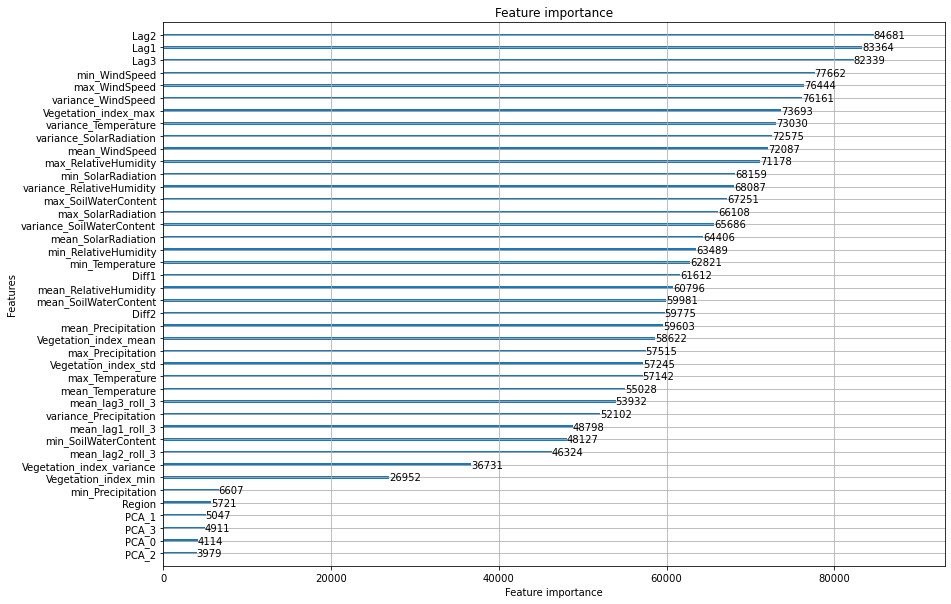

In [83]:
fig, ax = plt.subplots(figsize=(14,10))
lgb.plot_importance(m_lgb,ax =ax)

In [84]:
merged_df['Region'] = le.inverse_transform(merged_df['Region'])

In [105]:
_merged_df = merged_df.copy(deep=True)
_merged_df['combined'] = _merged_df['estimated_fire_area'].fillna(merged_df['pred'])
_merged_df

,Date,Region,estimated_fire_area,min_Precipitation,min_RelativeHumidity,min_SoilWaterContent,min_SolarRadiation,min_Temperature,min_WindSpeed,max_Precipitation,...,Lag1,Lag2,Lag3,Diff1,Diff2,mean_lag1_roll_3,mean_lag2_roll_3,mean_lag3_roll_3,pred,combined
0,2005-01-01,NSW,NaN,0.0,13.877194,0.002245,14.515009,14.485785,1.354448,1.836935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.171309,0.171309
1,2005-01-02,NSW,NaN,0.0,20.738882,0.001210,15.775055,12.067627,0.864556,6.854537,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.087543,0.087543
2,2005-01-03,NSW,NaN,0.0,26.145630,0.010889,15.362626,16.858456,1.435490,14.969810,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.139429,0.139429
3,2005-01-04,NSW,8.680000,0.0,31.279930,0.022578,7.576938,12.495799,1.401951,22.842566,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.657630,8.680000
4,2005-01-05,NSW,16.611250,0.0,24.466665,0.019950,14.087289,9.611800,1.011328,7.657155,...,8.680000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.436992,16.611250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40476,2020-10-27,WA,32.970000,0.0,8.379455,0.000000,17.794292,16.452520,1.234051,11.368348,...,89.475641,99.338400,100.242500,15.088843,48.537201,217.079419,149.123348,83.537139,33.584858,32.970000
40477,2020-10-28,WA,20.840625,0.0,11.057299,0.000000,17.875935,13.069478,1.142078,6.877861,...,32.970000,89.475641,99.338400,NaN,NaN,NaN,NaN,NaN,21.189671,20.840625
40478,2020-10-29,WA,136.083077,0.0,14.333677,0.000000,16.536827,13.965196,1.277926,5.021500,...,20.840625,32.970000,89.475641,NaN,NaN,NaN,NaN,NaN,135.962082,136.083077
40479,2020-10-30,WA,42.397895,0.0,11.337550,0.000000,17.236948,14.410994,1.830557,8.163377,...,136.083077,20.840625,32.970000,NaN,NaN,NaN,NaN,NaN,42.392439,42.397895


In [106]:
_merged_df['combined'] = np.where(_merged_df['combined'].lt(1), 1, _merged_df['combined'])

In [107]:
_merged_df

,Date,Region,estimated_fire_area,min_Precipitation,min_RelativeHumidity,min_SoilWaterContent,min_SolarRadiation,min_Temperature,min_WindSpeed,max_Precipitation,...,Lag1,Lag2,Lag3,Diff1,Diff2,mean_lag1_roll_3,mean_lag2_roll_3,mean_lag3_roll_3,pred,combined
0,2005-01-01,NSW,NaN,0.0,13.877194,0.002245,14.515009,14.485785,1.354448,1.836935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.171309,1.000000
1,2005-01-02,NSW,NaN,0.0,20.738882,0.001210,15.775055,12.067627,0.864556,6.854537,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.087543,1.000000
2,2005-01-03,NSW,NaN,0.0,26.145630,0.010889,15.362626,16.858456,1.435490,14.969810,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.139429,1.000000
3,2005-01-04,NSW,8.680000,0.0,31.279930,0.022578,7.576938,12.495799,1.401951,22.842566,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.657630,8.680000
4,2005-01-05,NSW,16.611250,0.0,24.466665,0.019950,14.087289,9.611800,1.011328,7.657155,...,8.680000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.436992,16.611250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40476,2020-10-27,WA,32.970000,0.0,8.379455,0.000000,17.794292,16.452520,1.234051,11.368348,...,89.475641,99.338400,100.242500,15.088843,48.537201,217.079419,149.123348,83.537139,33.584858,32.970000
40477,2020-10-28,WA,20.840625,0.0,11.057299,0.000000,17.875935,13.069478,1.142078,6.877861,...,32.970000,89.475641,99.338400,NaN,NaN,NaN,NaN,NaN,21.189671,20.840625
40478,2020-10-29,WA,136.083077,0.0,14.333677,0.000000,16.536827,13.965196,1.277926,5.021500,...,20.840625,32.970000,89.475641,NaN,NaN,NaN,NaN,NaN,135.962082,136.083077
40479,2020-10-30,WA,42.397895,0.0,11.337550,0.000000,17.236948,14.410994,1.830557,8.163377,...,136.083077,20.840625,32.970000,NaN,NaN,NaN,NaN,NaN,42.392439,42.397895


In [108]:
_merged_df['1_fill'] = np.where(_merged_df['estimated_fire_area'].isna(), 1, _merged_df['estimated_fire_area'])

In [113]:
_merged_df['Region'].unique()

array(['NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA'], dtype=object)

In [120]:
np.sqrt(mean_squared_error(_merged_df['combined'], _merged_df['1_fill']))

0.03700383014245829

In [118]:
_nsw = _merged_df.loc[_merged_df['Region'].eq('TA')]
_nsw

,Date,Region,estimated_fire_area,min_Precipitation,min_RelativeHumidity,min_SoilWaterContent,min_SolarRadiation,min_Temperature,min_WindSpeed,max_Precipitation,...,Lag2,Lag3,Diff1,Diff2,mean_lag1_roll_3,mean_lag2_roll_3,mean_lag3_roll_3,pred,combined,1_fill
23132,2005-01-01,TA,NaN,0.003973,43.906574,0.000000e+00,20.742302,6.686816,1.995647,13.604791,...,NaN,NaN,NaN,NaN,9.233333,NaN,NaN,0.017899,1.0,1.0
23133,2005-01-02,TA,NaN,0.001452,48.479427,5.487818e-07,16.284979,5.848104,2.660558,7.620975,...,NaN,NaN,-516.796339,-552.964874,582.539913,313.372562,32.289032,0.003223,1.0,1.0
23134,2005-01-03,TA,NaN,0.000211,56.439426,0.000000e+00,24.345411,11.170953,1.332753,12.761815,...,NaN,NaN,18.264678,-138.572336,104.038205,148.183605,134.859754,0.005744,1.0,1.0
23135,2005-01-04,TA,NaN,3.595669,82.454659,4.041164e-07,7.881971,8.998522,1.270749,23.429882,...,NaN,NaN,52.868715,206.307179,89.409676,37.483781,38.353994,0.000595,1.0,1.0
23136,2005-01-05,TA,NaN,0.201471,68.064865,8.472707e-07,6.821994,7.565962,2.077796,26.649889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001147,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28910,2020-10-27,TA,NaN,0.000000,64.655502,2.327530e-07,11.729219,5.966787,1.440288,5.084929,...,1.1,NaN,-14.316267,-9.292618,102.538990,92.973351,88.063953,0.069707,1.0,1.0
28911,2020-10-28,TA,NaN,0.002526,66.472710,0.000000e+00,12.221703,7.924917,0.937845,2.598302,...,3.3,1.1,-289.335708,-531.828473,348.869332,269.164337,88.480440,0.003788,1.0,1.0
28912,2020-10-29,TA,NaN,0.001300,73.726555,0.000000e+00,13.771194,8.499100,0.658886,6.297699,...,NaN,3.3,-17.120000,-23.537778,25.952593,NaN,NaN,0.003898,1.0,1.0
28913,2020-10-30,TA,NaN,0.000439,71.917526,0.000000e+00,16.116776,8.754771,0.744203,7.700192,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005581,1.0,1.0


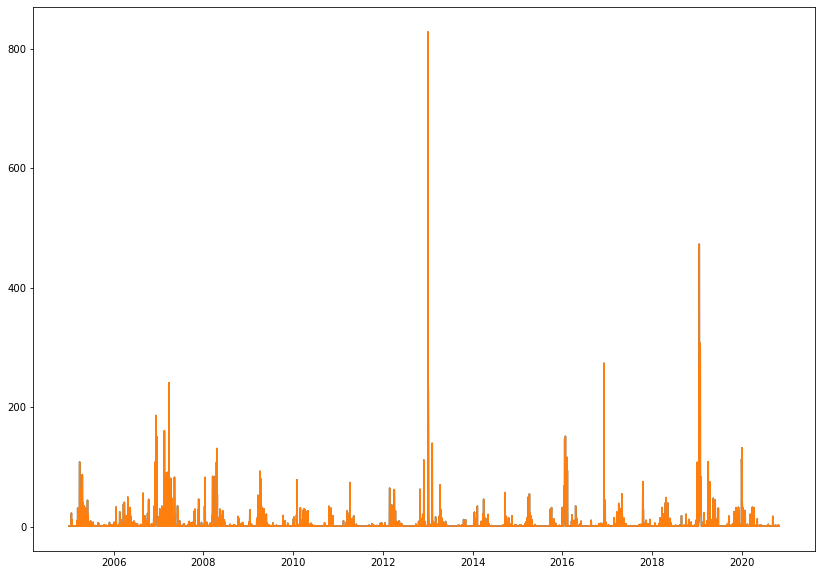

In [119]:
plt.figure(figsize=(14,10))
plt.plot(_nsw['Date'], _nsw['1_fill'])
plt.plot(_nsw['Date'], _nsw['combined'])

In [155]:
_solo = merged_df[['Date', 'Region', 'combined']]

In [156]:
_solo

,Date,Region,combined
0,2005-01-01,NSW,5.046563
1,2005-01-02,NSW,3.659374
2,2005-01-03,NSW,4.192812
3,2005-01-04,NSW,8.680000
4,2005-01-05,NSW,16.611250
...,...,...,...
40476,2020-10-27,WA,32.970000
40477,2020-10-28,WA,20.840625
40478,2020-10-29,WA,136.083077
40479,2020-10-30,WA,42.397895


In [160]:
_solo['combined'] = np.where(_solo['combined'].lt(1), 1, _solo['combined'])

C:\Users\albert\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [164]:
_final = _solo.pivot(index='Date', columns='Region', values='combined')

In [165]:
_final

Region,NSW,NT,QL,SA,TA,VI,WA
Date,,,,,,,
2005-01-01,5.046563,4.945000,38.831579,1.906863,1.146340,1.0,36.382500
2005-01-02,3.659374,1.320000,64.464286,2.417542,1.000000,2.8,148.106471
2005-01-03,4.192812,88.740000,47.386585,1.000000,1.000000,1.0,60.632258
2005-01-04,8.680000,5.802076,30.100000,1.000000,1.000000,1.0,86.374167
2005-01-05,16.611250,7.701433,4.000000,1.000000,1.000000,1.0,31.378947
...,...,...,...,...,...,...,...
2020-10-27,1.210000,12.750000,78.670769,1.214706,2.221335,1.0,32.970000
2020-10-28,3.000000,144.990566,119.608649,1.222701,1.000000,2.0,20.840625
2020-10-29,1.845141,53.462326,249.090625,1.000000,1.000000,1.0,136.083077


In [170]:
_final.to_csv('imputed_values.csv', index=False, header=True)

In [171]:
_final

Region,NSW,NT,QL,SA,TA,VI,WA
Date,,,,,,,
2005-01-01,5.046563,4.945000,38.831579,1.906863,1.146340,1.0,36.382500
2005-01-02,3.659374,1.320000,64.464286,2.417542,1.000000,2.8,148.106471
2005-01-03,4.192812,88.740000,47.386585,1.000000,1.000000,1.0,60.632258
2005-01-04,8.680000,5.802076,30.100000,1.000000,1.000000,1.0,86.374167
2005-01-05,16.611250,7.701433,4.000000,1.000000,1.000000,1.0,31.378947
...,...,...,...,...,...,...,...
2020-10-27,1.210000,12.750000,78.670769,1.214706,2.221335,1.0,32.970000
2020-10-28,3.000000,144.990566,119.608649,1.222701,1.000000,2.0,20.840625
2020-10-29,1.845141,53.462326,249.090625,1.000000,1.000000,1.0,136.083077


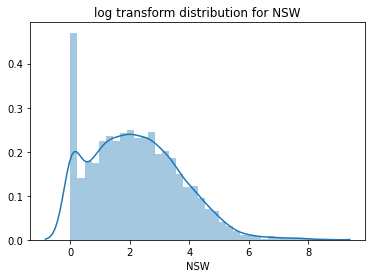

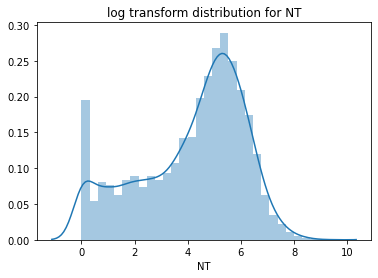

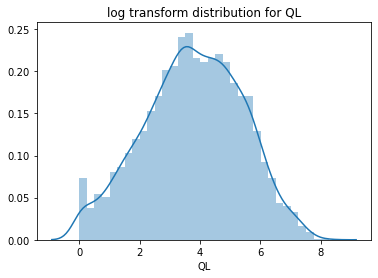

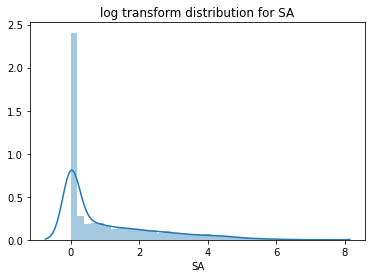

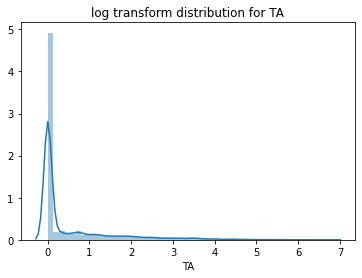

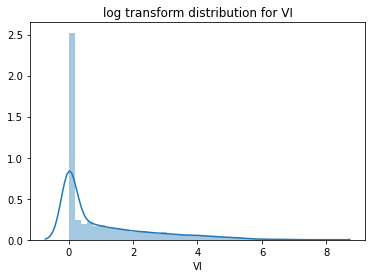

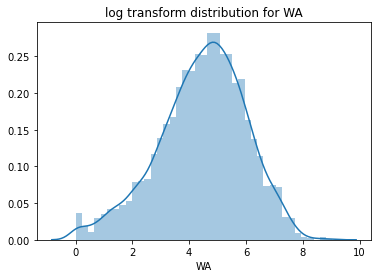

In [178]:
for i in _final.columns:
    sns.distplot(np.log(_final[i]))
    plt.title('log transform distribution for {}'.format(i))
    plt.show();

In [181]:
train = _final[:'2020-06-30']
test = _final['2020-07-01':]

In [190]:
def mean_absolute_percentage_error(y_true, y_pred):
    n = len(y_true)
    _sum = 0
    for i, x in zip(y_true, y_pred):
        _sum += np.abs((i - x)/i)
        
    return _sum/n

In [188]:
np.abs(-1)

1

In [193]:
# Dummy Regressor
dummy_regressor = pd.DataFrame(index= pd.date_range(start='2020-07-01', end = '2020-10-31'))
for i in train.columns:
    dummy_regressor[i] = train[i].mean()
    print('{} - rmse :'.format(i), np.sqrt(mean_squared_error(test[i], dummy_regressor[i])))
    print('{} - mape :'.format(i), mean_absolute_percentage_error(test[i], dummy_regressor[i]))
    print('------------------')

NSW - rmse : 34.13635219464219
NSW - mape : 17.289987587919487
------------------
NT - rmse : 160.94327256060075
NT - mape : 7.86344059830957
------------------
QL - rmse : 93.58575378445435
QL - mape : 4.186850652316096
------------------
SA - rmse : 13.027525214052451
SA - mape : 11.258688710646965
------------------
TA - rmse : 3.8491879759558887
TA - mape : 3.5865328988278193
------------------
VI - rmse : 17.555362226757808
VI - mape : 16.24987615914554
------------------
WA - rmse : 197.1712673053388
WA - mape : 18.759314593202962
------------------


In [194]:
train

Region,NSW,NT,QL,SA,TA,VI,WA
Date,,,,,,,
2005-01-01,5.046563,4.945000,38.831579,1.906863,1.14634,1.0,36.382500
2005-01-02,3.659374,1.320000,64.464286,2.417542,1.00000,2.8,148.106471
2005-01-03,4.192812,88.740000,47.386585,1.000000,1.00000,1.0,60.632258
2005-01-04,8.680000,5.802076,30.100000,1.000000,1.00000,1.0,86.374167
2005-01-05,16.611250,7.701433,4.000000,1.000000,1.00000,1.0,31.378947
...,...,...,...,...,...,...,...
2020-06-26,2.000000,180.530974,13.252500,1.000000,1.00000,1.0,21.952000
2020-06-27,2.292047,127.918605,19.451333,1.000000,1.00000,1.0,25.966667
2020-06-28,3.874097,61.197500,21.721000,1.000000,1.00000,1.0,21.771111
